In [1]:
# Load the data onto the Colab environment

from google.colab import files
uploaded = files.upload()

Saving healthcare-dataset-stroke-data.csv to healthcare-dataset-stroke-data.csv


In [2]:
# Importing all necessary packages

# chi-square test

!pip install researchpy

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_auc_score

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE


import seaborn as sns

import researchpy as rp
from scipy import stats

from io import StringIO
import pydotplus
from IPython.display import Image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Part 1 Data Acquisition & Cleaning

# Read data from a CSV file into a data frame

df = pd.read_csv('healthcare-dataset-stroke-data.csv') 

# Display the first ten rows of the data frame to examine if it is an individual-level data set
print(df.head(10))

# Display the variable list
print(df.columns.values)

# Display the number of rows and the number of columns in the data set to confirm the portrait shape
# The first element of the output is the number of rows and the second is the number of columns 
print(df.shape)

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   
5  56669    Male  81.0             0              0          Yes   
6  53882    Male  74.0             1              1          Yes   
7  10434  Female  69.0             0              0           No   
8  27419  Female  59.0             0              0          Yes   
9  60491  Female  78.0             0              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private    

In [4]:
# Part 1 continued: Missing Value Imputation & Data Exploration

# Drop id
rvar_list =['id']
df_sample1 = df.drop(columns=rvar_list)

# Drop 'N/A' values in 'bmi' column
df_sample2 = df_sample1.copy()

median_bmi = df_sample1['bmi'].median()
df_sample2['bmi'] = df_sample1['bmi'].fillna(median_bmi)

# Separate all the variables into two lists for future column indexing
# One for numerical, the other for categorical 
cvar_list = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status','stroke']
nvar_list = ['age', 'avg_glucose_level', 'bmi']

# Get the unique values of each categorical variables in the data frame
def column_unique_values(x_column):
  return list(x_column.unique())


# Drop the one observation with 'Other' in the 'gender' column
df_sample3 = df_sample2.copy()
df_sample3 = df_sample2.drop(df_sample2[df_sample2.gender == 'Other'].index)


print(df_sample3['smoking_status'].mode())

df_sample4 = df_sample3.copy()
df_sample4['smoking_status'] = df_sample3['smoking_status'].replace('Unknown', 'never smoked')


# Check if there is any missing value left
print(df_sample4[cvar_list].apply(column_unique_values))

df_sample4.isnull().sum()


0    never smoked
dtype: object
gender                                               [Male, Female]
hypertension                                                 [0, 1]
heart_disease                                                [1, 0]
ever_married                                              [Yes, No]
work_type         [Private, Self-employed, Govt_job, children, N...
Residence_type                                       [Urban, Rural]
smoking_status              [formerly smoked, never smoked, smokes]
stroke                                                       [1, 0]
dtype: object


gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

                        age  avg_glucose_level       bmi
age                1.000000           0.238323  0.324211
avg_glucose_level  0.238323           1.000000  0.167033
bmi                0.324211           0.167033  1.000000


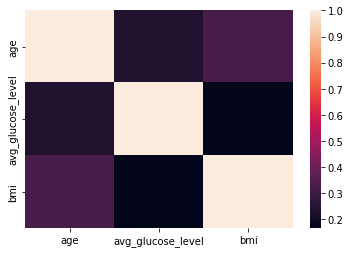

In [6]:
# Part 1 continued
# Draw a heat map for all the numerical variables in the data frame

# Placeholder variables: df4heatmaps
df4heatmaps = df_sample4.drop(columns=cvar_list)

# Compute the correlation matrix 
corr = df4heatmaps.corr()
# Print the correlation matrix
print(corr)
# Draw the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0, 0.5, 'age')

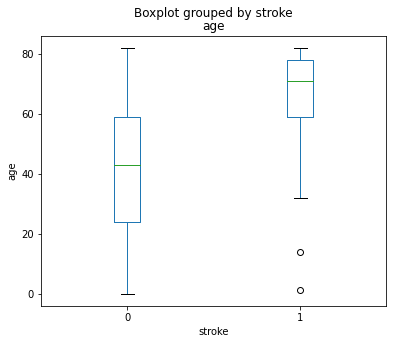

In [7]:
# Part 1 continued
# Draw a side-by-side box plot to detect if a categorical variable is correlated with a numerical variable

## age vs. stroke

x_var = 'stroke'
y_var = 'age'
df4ssb = df_sample4

# Generate the side-by-side box plot. ax is the side-by-side boxplot object
ax = df4ssb.boxplot(column=y_var, by=x_var, figsize=(6,5), grid=False)
# Set the label on the y-axis using set_ylabel method of the object ax
ax.set_ylabel(y_var)
# ax.get_figure().suptitle('Stroke vs. Age')

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0, 0.5, 'avg_glucose_level')

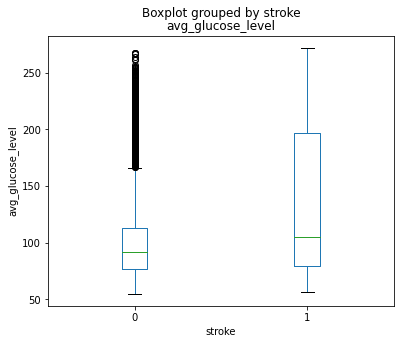

In [8]:
# Part 1 continued
# Draw a side-by-side box plot to detect if a categorical variable is correlated with a numerical variable

## avg_glucose_level vs. stroke

x_var = 'stroke'
y_var = 'avg_glucose_level'
df4ssb = df_sample4

# Generate the side-by-side box plot. ax is the side-by-side boxplot object
ax = df4ssb.boxplot(column=y_var, by=x_var, figsize=(6,5), grid=False)
# Set the label on the y-axis using set_ylabel method of the object ax
ax.set_ylabel(y_var)


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0, 0.5, 'bmi')

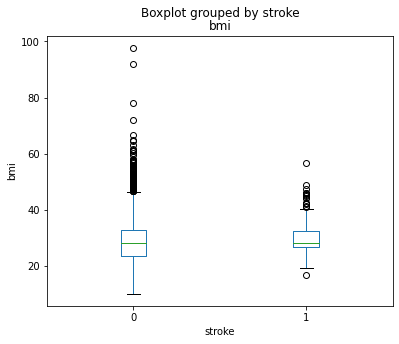

In [9]:
# Part 1 continued
# Draw a side-by-side box plot to detect if a categorical variable is correlated with a numerical variable

## bmi vs. stroke

x_var = 'stroke'
y_var = 'bmi'
df4ssb = df_sample4

# Generate the side-by-side box plot. ax is the side-by-side boxplot object
ax = df4ssb.boxplot(column=y_var, by=x_var, figsize=(6,5), grid=False)
# Set the label on the y-axis using set_ylabel method of the object ax
ax.set_ylabel(y_var)

In [10]:
# Part 1 continued
# chi-square test: gender vs. stroke
rp.summary_cat(df_sample4[['gender', 'stroke']])

,Variable,Outcome,Count,Percent
0,gender,Female,2994,58.60
1,,Male,2115,41.40
2,stroke,0,4860,95.13
3,,1,249,4.87


In [11]:
# Part 1 continued
crosstab = pd.crosstab(df_sample4['gender'], df_sample4['stroke'])
crosstab

stroke,0,1
gender,,
Female,2853,141
Male,2007,108


In [12]:
# Part 1 continued
# (chi-square value, p-value, degree of freedom, expected frequencies)
stats.chi2_contingency(crosstab)

(0.340002536046177,
 0.5598277580669416,
 1,
 array([[2848.07985907,  145.92014093],
        [2011.92014093,  103.07985907]]))

In [13]:
# Part 1 continued
# chi-square test: hypertension vs. stroke
crosstab = pd.crosstab(df_sample4['hypertension'], df_sample4['stroke'])
crosstab

stroke,0,1
hypertension,,
0,4428,183
1,432,66


In [14]:
# Part 1 continued
stats.chi2_contingency(crosstab)

(81.57314462043591,
 1.688936253410575e-19,
 1,
 array([[4386.27128597,  224.72871403],
        [ 473.72871403,   24.27128597]]))

In [15]:
# Part 1 continued
# chi-square test: heart_disease vs. stroke
crosstab = pd.crosstab(df_sample4['heart_disease'], df_sample4['stroke'])
crosstab

stroke,0,1
heart_disease,,
0,4631,202
1,229,47


In [16]:
# Part 1 continued
stats.chi2_contingency(crosstab)

(90.22943664078221,
 2.120831133146208e-21,
 1,
 array([[4597.45155608,  235.54844392],
        [ 262.54844392,   13.45155608]]))

In [17]:
# Part 1 continued
# chi-square test: ever_married vs. stroke
crosstab = pd.crosstab(df_sample4['ever_married'], df_sample4['stroke'])
crosstab

stroke,0,1
ever_married,,
No,1727,29
Yes,3133,220


In [18]:
# Part 1 continued
stats.chi2_contingency(crosstab)

(58.86780922483486,
 1.6862856191673454e-14,
 1,
 array([[1670.41691133,   85.58308867],
        [3189.58308867,  163.41691133]]))

In [19]:
# Part 1 continued
# chi-square test: Residence_type vs. stroke
crosstab = pd.crosstab(df_sample4['Residence_type'], df_sample4['stroke'])
crosstab

stroke,0,1
Residence_type,,
Rural,2399,114
Urban,2461,135


In [20]:
# Part 1 continued
stats.chi2_contingency(crosstab)

(1.0749713079092142,
 0.29982523877153633,
 1,
 array([[2390.52260716,  122.47739284],
        [2469.47739284,  126.52260716]]))

In [21]:
# Part 1 continued
# chi-square test: work_type vs. stroke
crosstab = pd.crosstab(df_sample4['work_type'], df_sample4['stroke'])
crosstab

stroke,0,1
work_type,,
Govt_job,624,33
Never_worked,22,0
Private,2775,149
Self-employed,754,65
children,685,2


In [22]:
# Part 1 continued
stats.chi2_contingency(crosstab)

(49.1591485868476,
 5.40903546949726e-10,
 4,
 array([[6.24979448e+02, 3.20205520e+01],
        [2.09277745e+01, 1.07222548e+00],
        [2.78149149e+03, 1.42508514e+02],
        [7.79083969e+02, 3.99160305e+01],
        [6.53517322e+02, 3.34826776e+01]]))

In [23]:
# Part 1 continued
# chi-square test: smoking_status vs. stroke
crosstab = pd.crosstab(df_sample4['smoking_status'], df_sample4['stroke'])
crosstab

stroke,0,1
smoking_status,,
formerly smoked,814,70
never smoked,3299,137
smokes,747,42


In [24]:
# Part 1 continued
stats.chi2_contingency(crosstab)

(23.84575807229389,
 6.636810633518104e-06,
 2,
 array([[ 840.91603053,   43.08396947],
        [3268.53787434,  167.46212566],
        [ 750.54609513,   38.45390487]]))

In [25]:
# Part 1 continued
# chi-sqaure post hoc test for work_type and smoking_status

## work type
dummies = pd.get_dummies(df_sample4['work_type'])

for series in dummies:
  crosstab = pd.crosstab(dummies[f'{series}'], df_sample4['stroke'])
  print(crosstab, '\n')
  chi2, p, dof, ecpected = stats.chi2_contingency(crosstab)
  print(f'Chi2 value = {chi2}, p-value = {p}, df = {dof}')
  print()


stroke       0    1
Govt_job           
0         4236  216
1          624   33 

Chi2 value = 0.008660334140911895, p-value = 0.9258551669275809, df = 1

stroke           0    1
Never_worked           
0             4838  249
1               22    0 

Chi2 value = 0.32242006724269884, p-value = 0.570156890083992, df = 1

stroke      0    1
Private           
0        2085  100
1        2775  149 

Chi2 value = 0.6191734473868207, p-value = 0.4313546039669218, df = 1

stroke            0    1
Self-employed           
0              4106  184
1               754   65 

Chi2 value = 18.955485547287754, p-value = 1.3380401602010203e-05, df = 1

stroke       0    1
children           
0         4175  247
1          685    2 

Chi2 value = 34.82046070158722, p-value = 3.615537224238463e-09, df = 1



In [26]:
# Part 1 continued
# smoking status
dummies = pd.get_dummies(df_sample4['smoking_status'])

for series in dummies:
  crosstab = pd.crosstab(dummies[f'{series}'], df_sample4['stroke'])
  print(crosstab, '\n')
  chi2, p, dof, ecpected = stats.chi2_contingency(crosstab)
  print(f'Chi2 value = {chi2}, p-value = {p}, df = {dof}')
  print()

stroke              0    1
formerly smoked           
0                4046  179
1                 814   70 

Chi2 value = 20.588666991495394, p-value = 5.6932145282837105e-06, df = 1

stroke           0    1
never smoked           
0             1561  112
1             3299  137 

Chi2 value = 17.20949941122615, p-value = 3.3475824871454873e-05, df = 1

stroke     0    1
smokes           
0       4113  207
1        747   42 

Chi2 value = 0.2999841198085903, p-value = 0.5838923763940107, df = 1



In [27]:
# Part 2: Logistic Regression - Variable Transformation

# Standardize the numerical variables 
df_sample5 = df_sample4.copy()
df_sample5[nvar_list] = (df_sample4[nvar_list] - df_sample4[nvar_list].mean())/df_sample4[nvar_list].std()

# Set the datatype for the variables in the cvar_list to be categorical in Python
# Set the datatype for the variables in the nvar_list to be numerical in Python 
df_sample6 = df_sample5.copy()
df_sample6[cvar_list] = df_sample5[cvar_list].astype('category')
df_sample6[nvar_list] = df_sample5[nvar_list].astype('float64')


# Convert the categorical variables into dummies (Step 1 of dummy coding)
# prefix_sep is the sympol used to create the dummy variable names.

df_sample7 = df_sample6.copy()
df_sample7 = pd.get_dummies(df_sample6, prefix_sep='_')

# Remove the redundant dummies (Step 2 of dummy coding)
# Placeholder variable: rdummies
rdummies = ['gender_Male', 'hypertension_0', 'heart_disease_0', 'ever_married_No', 'work_type_Govt_job', 'Residence_type_Rural', 'smoking_status_formerly smoked', 'stroke_0']
df_sample8 = df_sample7.copy()
df_sample8 = df_sample7.drop(columns=rdummies)

# Get the remaining variable list after the variable transformation
print(df_sample8.columns.values)

# Display the milestone dataframe
print(df_sample8)



['age' 'avg_glucose_level' 'bmi' 'gender_Female' 'hypertension_1'
 'heart_disease_1' 'ever_married_Yes' 'work_type_Never_worked'
 'work_type_Private' 'work_type_Self-employed' 'work_type_children'
 'Residence_type_Urban' 'smoking_status_never smoked'
 'smoking_status_smokes' 'stroke_1']
           age  avg_glucose_level       bmi  gender_Female  hypertension_1  \
0     1.051139           2.706185  1.004794              0               0   
1     0.785812           2.121444 -0.099133              1               0   
2     1.626015          -0.004867  0.472312              0               0   
3     0.255157           1.437332  0.719072              1               0   
4     1.581794           1.501150 -0.631615              1               1   
...        ...                ...       ...            ...             ...   
5105  1.626015          -0.494433 -0.099133              1               1   
5106  1.670236           0.420881  1.446365              1               0   
5107 -0.36

In [28]:
# Part 2 continued - Data Partition

df4partition = df_sample8

testpart_size = 0.2

df_nontestData, df_testData = train_test_split(df4partition, test_size = testpart_size, random_state = 1)

print(df_nontestData)
print(df_testData)

           age  avg_glucose_level       bmi  gender_Female  hypertension_1  \
4153  1.581794          -0.753017 -0.683565              0               1   
4052  1.360688          -0.838255 -0.203032              1               0   
5076 -0.408161           1.506671 -0.761489              1               0   
874   1.626015          -1.085357 -0.280956              0               0   
3535  0.255157          -0.461751 -0.449792              1               0   
...        ...                ...       ...            ...             ...   
2895  0.122493           0.698456  0.056716              0               0   
2763  0.078272          -0.936522  0.407375              1               0   
905  -0.540825          -0.659830  0.874921              1               0   
3981  1.316466          -0.655634 -0.021208              0               0   
235   1.095360           2.316873  1.355453              1               0   

      heart_disease_1  ever_married_Yes  work_type_Never_worked

In [29]:
# Part 2 continued: Running logistic regression with a pre specified alpha to identify the most and least important predictors. 

DV = 'stroke_1'
y = df_nontestData[DV]
X = df_nontestData.drop(columns = [DV])

alpha = 12

clf = LogisticRegression(C = 1/alpha, penalty = 'l1', solver = 'saga', max_iter = 2000, random_state = 1).fit(X,y)

def summary_coef(model_object):
  n_predictors = X.shape[1]
  model_coef = pd.DataFrame(model_object.coef_.reshape(1, n_predictors), columns = X.columns.values)
  model_coef['Intercept'] = model_object.intercept_
  return model_coef.transpose()


print(summary_coef(clf))

                                    0
age                          1.439359
avg_glucose_level            0.172358
bmi                          0.000000
gender_Female                0.000000
hypertension_1               0.022127
heart_disease_1              0.000000
ever_married_Yes             0.000000
work_type_Never_worked       0.000000
work_type_Private            0.000000
work_type_Self-employed      0.000000
work_type_children           0.000000
Residence_type_Urban         0.000000
smoking_status_never smoked  0.000000
smoking_status_smokes        0.000000
Intercept                   -3.857798


In [30]:
# Part 2 continued: Running logistic regression with cross validation

kfolds = 5

min_alpha = 0.001

max_alpha = 100

n_candidates = 1000

import numpy as np

alpha_list = list(np.linspace(min_alpha, max_alpha, num = n_candidates))

C_list = list(1/np.linspace(min_alpha, max_alpha, num = n_candidates))

clf_optimal = LogisticRegressionCV(Cs = C_list, cv = kfolds, penalty = 'l1', solver = 'saga', max_iter = 5000, random_state = 1, n_jobs = -1).fit(X,y)

print(summary_coef(clf_optimal))

print(1/clf_optimal.C_)

# y_test_actual is the actual values of the DV in the test partition
y_test_actual = df_testData[DV]

# X_test is the predictor values in the test partition
X_test = df_testData.drop(columns=[DV])

# Use predict method of the clf_optimal object to apply the model associated with clf_optimal to the test partition
# y_test_predicted is the predicted values of the DV in the test partition 
y_test_predicted = clf_optimal.predict(X_test)


# Display the confusion matrix over the test partition
print(metrics.confusion_matrix(y_test_actual, y_test_predicted))

# Display the accuracy over the test partition
print(clf_optimal.score(X_test, y_test_actual))

                                    0
age                          1.596337
avg_glucose_level            0.183235
bmi                          0.000000
gender_Female                0.066077
hypertension_1               0.331337
heart_disease_1              0.229323
ever_married_Yes            -0.385241
work_type_Never_worked       0.000000
work_type_Private            0.194559
work_type_Self-employed     -0.096496
work_type_children           0.000000
Residence_type_Urban         0.104209
smoking_status_never smoked -0.078182
smoking_status_smokes        0.000000
Intercept                   -3.909809
[2.10308108]
[[962   0]
 [ 60   0]]
0.9412915851272016


In [31]:
# Part 2 continued: Applying SMOTE to account for the rare event problem [Note: This takes about 5 mins to run]

DV = 'stroke_1'
y = df_nontestData[DV]
X = df_nontestData.drop(columns=[DV])


imba_pipeline = make_pipeline(SMOTE(random_state=1), 
                              LogisticRegression(penalty='l1', solver='saga', max_iter=5000, random_state=1))

param_grid = {'C': C_list}

new_params = {'logisticregression__' + key: param_grid[key] for key in param_grid}

grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kfolds, n_jobs=-1)
grid_imba.fit(X,y)
clf_optimal_imba = grid_imba.best_estimator_.named_steps['logisticregression']

In [32]:
# Display the estimated coefficients of the final selected model
print(summary_coef(clf_optimal_imba))

# Display the optimal alpha that yields the final selected model (the best model candidate)
print(1/clf_optimal_imba.C)

# Calcuate the error rate over the test partition based on the final selected model

# y_test_actual is the actual values of the DV in the test partition
y_test_actual = df_testData[DV]

# X_test is the predictor values in the test partition
X_test = df_testData.drop(columns=[DV])

# Use predict method of the clf_optimal object to apply the model associated with clf_optimal to the test partition
# y_test_predicted is the predicted values of the DV in the test partition 
y_test_predicted = clf_optimal_imba.predict(X_test)

# Display the confusion matrix over the test partition
print(metrics.confusion_matrix(y_test_actual, y_test_predicted))

# Display the accuracy over the test partition
print(clf_optimal_imba.score(X_test, y_test_actual))

                                    0
age                          2.051125
avg_glucose_level            0.186028
bmi                         -0.009840
gender_Female               -0.118626
hypertension_1              -0.334817
heart_disease_1             -0.579004
ever_married_Yes            -0.753097
work_type_Never_worked      -0.362236
work_type_Private           -0.208657
work_type_Self-employed     -0.847223
work_type_children          -0.306506
Residence_type_Urban        -0.184123
smoking_status_never smoked -0.846583
smoking_status_smokes       -0.950712
Intercept                    0.441795
0.6015945945945946
[[715 247]
 [ 17  43]]
0.7416829745596869


In [33]:
# Part 3: Nearest neighbor approach

# Separate the predictor values and the DV values into X and y respectively
# Placeholder variable: DV
DV = 'stroke_1'
y = df_nontestData[DV]
X = df_nontestData.drop(columns=[DV])

# First we build a kNN model with pre-specified k
k = 5

clf = KNeighborsClassifier(metric='euclidean', n_neighbors=k).fit(X,y)

# Report the performance over the test partition

X_test = df_testData.drop(columns=DV)
y_test = df_testData[DV]

model_object = clf

# obtain the AUC of the k-NN model with k=5
print(metrics.roc_auc_score(y_test, model_object.predict_proba(X_test)[:, 1]))

0.6201923076923076


In [34]:
# Part 3 continued: Nearest neighbor with cross validation [Note: Takes about a minute to run]

# Run Nearest neighbor with k-fold cross validation
# Placeholder variable: kfolds
kfolds = 5

# We first define the search scope. k (k-th nearest neighbor) will be increased from 1 to max_k
max_k = 200

param_grid = {'n_neighbors': list(range(1, max_k+1))}

# Set n_jobs to be -1 to run  on all CPU cores.
# The search criterion is to find the model that maximizes 
# whatever the scoring function - for this case roc_auc - returns.


gridsearch = GridSearchCV(KNeighborsClassifier(metric='euclidean'), param_grid, scoring='roc_auc', cv=kfolds, n_jobs=-1)
gridsearch.fit(X,y)
clf_bestkNN = gridsearch.best_estimator_

In [35]:
# Part 3 continued: Displaying the results of the optimal nearest neighbor approach

# Display the optimal k (k-th nearest neighbor)
print(clf_bestkNN.n_neighbors)

# y_test_actual is the actual values of the DV in the test partition
y_test_actual = df_testData[DV]

# X_test is the predictor values in the test partition
X_test = df_testData.drop(columns=[DV])

# Get the AUC of the final selected k-NN model

print(roc_auc_score(y_test_actual, clf_bestkNN.predict_proba(X_test)[:,1]))

185
0.8356981981981982


In [36]:
# Part 3: Classification Tree - Preparing and partitioning the data

# Set the datatype for the variables in the cvar_list to be categorical in Python
# Set the datatype for the variables in the nvar_list to be numerical in Python 
df_sample5 = df_sample4.copy()
df_sample5[cvar_list] = df_sample2[cvar_list].astype('category')
df_sample5[nvar_list] = df_sample2[nvar_list].astype('float64')

# Convert the categorical variables into dummies (Step 1 of dummy coding)
# prefix_sep is the sympol used to create the dummy variable names.

df_sample6 = df_sample5.copy()
df_sample6 = pd.get_dummies(df_sample6, prefix_sep='_')

# Remove the redundant dummies (Step 2 of dummy coding)
# Placeholder variable: rdummies
rdummies = ['gender_Male', 'hypertension_0', 'heart_disease_0', 'ever_married_No', 'work_type_Govt_job', 'Residence_type_Rural', 'smoking_status_formerly smoked', 'stroke_0']
df_sample7 = df_sample6.copy()
df_sample7 = df_sample6.drop(columns=rdummies)


# Placeholder variables: df4partition, testpart_size
# test_size specifies the percentage for the test partition
df4partition_CT = df_sample7
testpart_size = 0.2

# random_state specifies the seed for random number generator. 
# random_state = 1 unless otherwised noted
df_nontestData_CT, df_testData_CT = train_test_split(df4partition_CT, test_size=testpart_size, random_state=1)

print(df_nontestData_CT)

       age  avg_glucose_level   bmi  gender_Female  gender_Other  \
4153  79.0              72.04  23.6              0             0   
4052  74.0              68.18  27.3              1             0   
5076  34.0             174.37  23.0              1             0   
874   80.0              56.99  26.7              0             0   
3535  49.0              85.23  25.4              1             0   
...    ...                ...   ...            ...           ...   
2895  46.0             137.77  29.3              0             0   
2763  45.0              63.73  32.0              1             0   
905   31.0              76.26  35.6              1             0   
3981  73.0              76.45  28.7              0             0   
235   68.0             211.06  39.3              1             0   

      hypertension_1  heart_disease_1  ever_married_Yes  \
4153               1                0                 1   
4052               0                0                 1   
5076  

In [37]:
# Part 3 continued: Defining a funtion to display the tree

# Separate the predictor values and the DV values into X and y respectively
# Placeholder variable: DV
DV = 'stroke_1'
y = df_nontestData_CT[DV]
X = df_nontestData_CT.drop(columns=[DV])



# A user-defined function summary_tree to display a classification tree
def summary_tree(model_object):
  dot_data = StringIO()
  export_graphviz(model_object, out_file=dot_data, filled=True,
                  rounded=True, special_characters=True, feature_names=X.columns.values,
                  class_names=['0', '1'])
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
  output_imagefile = 'tree.png'
  graph.write_png(output_imagefile)
  return output_imagefile


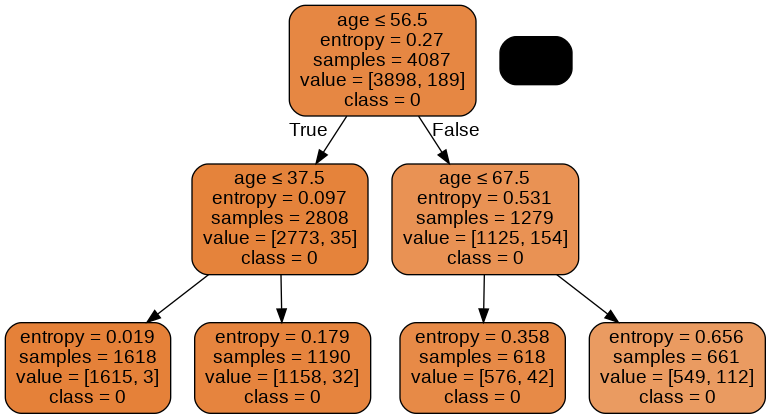

In [38]:
# Part 3 continued: Generating the initial classification tree

# Run Classification tree with k-fold cross validation with k=5
# Placeholder variable: kfolds
kfolds = 5

# Here we specify within which range of depths we will search for the best pruned tree
maximum_depth = 100
minimum_depth = 1

param_grid = {'max_depth': list(range(minimum_depth, maximum_depth+1))}


gridsearch = GridSearchCV(DecisionTreeClassifier(criterion='entropy', random_state=1), param_grid, scoring='roc_auc', cv=kfolds, n_jobs=-1)
gridsearch.fit(X,y)
clf_BPT = gridsearch.best_estimator_

# Display the resulting best pruned tree
Image(summary_tree(clf_BPT))


In [40]:
# Part 3 continued: measuring the accuracy of the classification tree

# Display the level of depth of the best pruned tree
print(clf_BPT.get_depth())

# y_test_actual is the actual values of the DV in the test partition
y_test_actual = df_testData_CT[DV]

# X_test is the predictor values in the test partition
X_test = df_testData_CT.drop(columns=[DV])


# Get the AUC of the best pruned tree model
print(roc_auc_score(y_test_actual, clf_BPT.predict_proba(X_test)[:,1]))

2
0.8366857241857242


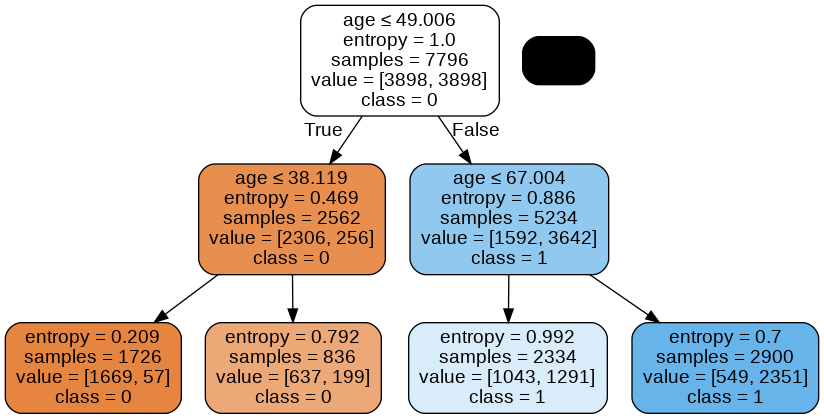

In [41]:
# Part 3 continued: Generating a classification tree with SMOTE 

imba_pipeline = make_pipeline(SMOTE(random_state=1), 
                              DecisionTreeClassifier(criterion='entropy', random_state=1))

new_params = {'decisiontreeclassifier__' + key: param_grid[key] for key in param_grid}

grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kfolds, scoring='roc_auc', n_jobs=-1)
grid_imba.fit(X,y)
clf_BPT_imba = grid_imba.best_estimator_.named_steps['decisiontreeclassifier']

Image(summary_tree(clf_BPT_imba))

In [42]:
# Part 3 continued: Displaying the accuracy of the final tree
print(clf_BPT_imba.get_depth())

# y_test_actual is the actual values of the DV in the test partition
y_test_actual = df_testData_CT[DV]

# X_test is the predictor values in the test partition
X_test = df_testData_CT.drop(columns=[DV])


# Get the AUC of the best pruned tree model

print(roc_auc_score(y_test_actual, clf_BPT_imba.predict_proba(X_test)[:,1]))

2
0.8255370755370754


In [43]:
# Part 3 continued: Displaying the rules

# The user-defined function for getting the tree path
# Author: Federico Ibba on stackoverflow.com 
# Created date: Jan 19, 2018
# URL: https://stackoverflow.com/questions/32506951/how-to-explore-a-decision-tree-built-using-scikit-learn/35911666
# Modified by Lin Hao during Oct. 2020

def get_treepaths(dtc, df):
    rules_list = []
    values_path = []
    values = dtc.tree_.value

    def RevTraverseTree(tree, node, rules, pathValues):
        try:
            prevnode = tree[2].index(node)           
            leftright = '<='
            pathValues.append(values[prevnode])
        except ValueError:
            # failed, so find it as a right node - if this also causes an exception, something's really f'd up
            prevnode = tree[3].index(node)
            leftright = '>'
            pathValues.append(values[prevnode])

        # now let's get the rule that caused prevnode to -> node
        p1 = df.columns[tree[0][prevnode]]    
        p2 = tree[1][prevnode]    
        rules.append(str(p1) + ' ' + leftright + ' ' + str(p2))

        # if we've not yet reached the top, go up the tree one more step
        if prevnode != 0:
            RevTraverseTree(tree, prevnode, rules, pathValues)

    # get the nodes which are leaves
    leaves = dtc.tree_.children_left == -1
    leaves = np.arange(0,dtc.tree_.node_count)[leaves]

    # build a simpler tree as a nested list: [split feature, split threshold, left node, right node]
    thistree = [dtc.tree_.feature.tolist()]
    thistree.append(dtc.tree_.threshold.tolist())
    thistree.append(dtc.tree_.children_left.tolist())
    thistree.append(dtc.tree_.children_right.tolist())

    # get the decision rules for each leaf node & apply them
    for (ind,nod) in enumerate(leaves):

        # get the decision rules
        rules = []
        pathValues = []
        RevTraverseTree(thistree, nod, rules, pathValues)

        pathValues.insert(0, values[nod])      
        pathValues = list(reversed(pathValues))

        rules = list(reversed(rules))

        rules_list.append(rules)
        values_path.append(pathValues)

    for i in range(len(rules_list)):
      
      print('\nLeaf node ID =', i+1)
      print('Path =', rules_list[i])
      distro = sum(values_path[i][-1])
      print('sample =', int(sum(distro)))
      print('value =', list([int(distro[0]), int(distro[1])]))
      predicted_class = 1 if distro[1] > distro[0] else 0
      print('class = ', predicted_class)
      
    return None

get_treepaths(dtc=clf_BPT_imba, df=df_nontestData)


Leaf node ID = 1
Path = ['age <= 49.00570487976074', 'age <= 38.11854553222656']
sample = 1726
value = [1669, 57]
class =  0

Leaf node ID = 2
Path = ['age <= 49.00570487976074', 'age > 38.11854553222656']
sample = 836
value = [637, 199]
class =  0

Leaf node ID = 3
Path = ['age > 49.00570487976074', 'age <= 67.00444412231445']
sample = 2334
value = [1043, 1291]
class =  1

Leaf node ID = 4
Path = ['age > 49.00570487976074', 'age > 67.00444412231445']
sample = 2900
value = [549, 2351]
class =  1
